Copyright (c) 2025 Mitsuru Ohno  
Use of this source code is governed by a BSD-3-style  
license that can be found in the LICENSE file.  

## 当ノートブックのワークフロー  
1. csvに書き込んだ反応式を読み込む。ただし速度定数はすべて既知とする  
2. 化学種ごとの微分型の反応速度式を作成する  
3. 作成した微分方程式を、数値解析可能な形式にする  
4. 化学種ごとの濃度の経時変化を求める  
5. 経時変化と実験点を図示する  

## 引用文献  
3) Kentaro TAMAKI, Seiichi YADA, Shiro KUDO, Reaction of 3- (1-Naphthyloxy) -2-hydroxy-1-propyltosylate with Isopropylamine, Journal of Synthetic Organic Chemistry, Japan, 1972, Volume 30, Issue 2, Pages 175-178, Released on J-STAGE November 13, 2009, Online ISSN 1883-6526, Print ISSN 0037-9980, https://doi.org/10.5059/yukigoseikyokaishi.30.175, https://www.jstage.jst.go.jp/article/yukigoseikyokaishi1943/30/2/30_2_175/_article/-char/en  

- 文献中表1 アセトニトリル溶媒のデータ、および式 [1] の反応式を用いた。  
- 併発反応と逐次反応が共存する系を例示した。  

## 使用方法の要約
基本的な使用: RxnIVPsolv("sample_data.csv")でインスタンス化  
数値積分: get_ode_system()で必要なオブジェクトを取得  
エラーハンドリング: try-except文でエラーをキャッチ  
可視化: matplotlibで結果をプロット  
パラメータ解析: 異なる初期条件での比較  
これらの使用例は、現在のコードが正しく動作することを前提としています。もしエラーが発生した場合は、debug_ode_system()メソッドで詳細な情報を確認できます。  

## 反応式を記載したcsvファイルを指定する  

In [1]:
file_path = '../sample_data/ref3/sample_rxn_ref3AN_litk.csv'  # CSVファイルのパスを指定

## 反応速度式をscipy.integrate.solve_ivpで処理できる連立微分方程式にする  

In [3]:
from dataclasses import dataclass, field
from typing import Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

from rxnfit.build_ode import RxnODEbuild
from rxnfit.solv_ode import SolverConfig, RxnODEsolver
from rxnfit.expdata_reader import expdata_read

In [4]:
builded_rxnode = RxnODEbuild(file_path)

In [5]:
builded_rxnode.get_ode_info(debug_info=True)

number of species: 3
unique species: ['Tos', 'Prop', 'Nep']
rate constant: {'k1': 0.004, 'k2': 0.009, 'k3': 0.02}

=== debug info ===
Successfully created function for Tos with args: ['t', 'Tos', 'Prop', 'Nep']
Successfully created function for Prop with args: ['t', 'Tos', 'Prop', 'Nep']
Successfully created function for Nep with args: ['t', 'Tos', 'Prop', 'Nep']
order of args: ['t', 'Tos', 'Prop', 'Nep']
system of ODE: {'Tos': '-k1*Tos(t)-k2*Tos(t)', 'Prop': 'k1*Tos(t)+k3*Nep(t)', 'Nep': 'k2*Tos(t)-k3*Nep(t)'}


In [6]:
builded_rxnode.rate_consts_dict

{'k1': 0.004, 'k2': 0.009, 'k3': 0.02}

## 数値積分を実行する  

In [7]:
# get_ode_infoの出力を参照して、初期値等の入力項目を渡す
config = SolverConfig(
    y0 = [0.3, 0.0, 0.0], # 初期濃度（必須）
    t_span=(0, 240),         # 時間範囲（必須）
    # t_eval: Optional[np.ndarray] = field(default=None),  # 任意
    method = "RK45",  # 任意
    rtol = 1e-6,    # 任意    
)

In [8]:
# 基本的な数値積分 -インスタンス化-
solved_rxnode = RxnODEsolver(builded_rxnode, config)

In [9]:
ode_construct, sol = solved_rxnode.solve_system()

Successfully created function for Tos with args: ['t', 'Tos', 'Prop', 'Nep']
Successfully created function for Prop with args: ['t', 'Tos', 'Prop', 'Nep']
Successfully created function for Nep with args: ['t', 'Tos', 'Prop', 'Nep']


## 経時変化の実験データを読み込み　　
### データフレーム化  

In [10]:
file_path_data = '../sample_data/ref3/sample_timecourse_ref3AN.csv' # データファイルのパス
df1 = pd.read_csv(file_path_data)

expdata_read([df1,])  # 複数データフレームのリストを渡すとまとめて読み込み可能

[([array([ 15,  30,  60, 120, 240]),
   array([ 15,  30,  60, 120, 240]),
   array([ 15,  30,  60, 120, 240])],
  [array([0.24, 0.22, 0.13, 0.04, 0.01]),
   array([0.03 , 0.06 , 0.07 , 0.03 , 0.001]),
   array([0.02, 0.05, 0.11, 0.22, 0.27])])]


=== Time-course plot ===


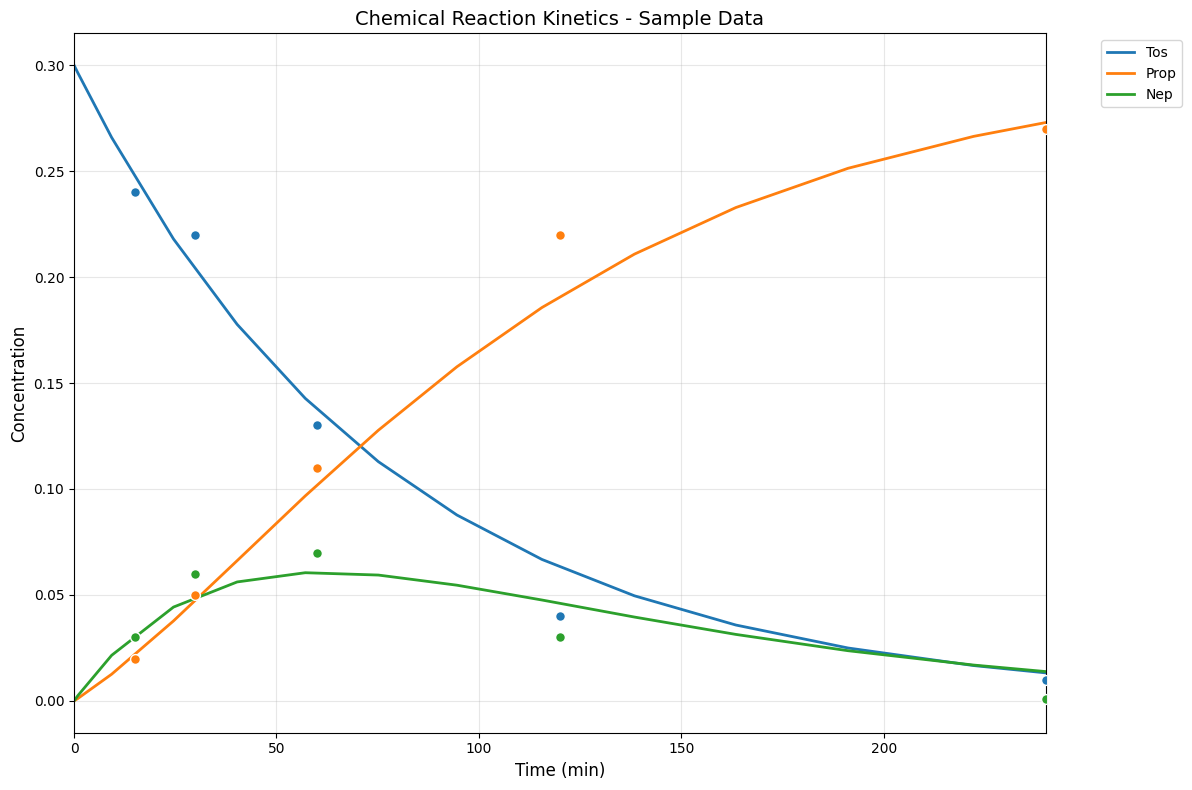


=== Concentration at the final time point ===
Tos: 0.013247
Prop: 0.272895
Nep: 0.013858


In [11]:
solved_rxnode.solution_plot(expdata_df=df1)

## 微分方程式の解を数値として表示する  

In [12]:
df_solvd = solved_rxnode.to_dataframe(time_column_name="min")
df_solvd

,min,Tos,Prop,Nep
0,0.000000,0.300000,0.000000,0.000000
1,0.083722,0.299674,0.000101,0.000226
2,0.920946,0.296430,0.001121,0.002449
3,9.293177,0.265860,0.012611,0.021528
4,24.572383,0.217967,0.037748,0.044286
5,40.298761,0.177665,0.066189,0.056146
6,57.136095,0.142738,0.096765,0.060497
7,75.172602,0.112904,0.127702,0.059394
8,94.583146,0.087725,0.157661,0.054615
9,115.583821,0.066766,0.185615,0.047619


## 与えた速度定数で解と、実験値の残渣二乗和    
実験の時間で再積分して残差二乗和（表示あり）  

In [13]:
rss = solved_rxnode.rsq(df1)

Residual sum of squares: 0.00248538
